# Maximizing Customer Retention: Fairway Bank (Modeling 3)

With models tuned and probability thresholds set, we will now compare our suite of models and choose a best submission to present to stakeholders. The previous round of modeling can be found  __[here](https://github.com/da42ru/Fairway_Bank_Churn_Reduction/blob/main/notebooks/04_modeling.ipynb)__.

## Load Libraries

In [471]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold

import pickle

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, recall_score, f1_score, precision_score, accuracy_score, roc_auc_score

import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [10]:
df = pd.read_csv('bank_4.csv', index_col=0)

In [11]:
df.head()

,credit_score,gender,age,tenure,balance,num_products,credit_card,active,salary,churn,...,points,country_F,country_G,country_S,card_D,card_G,card_P,card_S,umap_1,umap_2
0,1,0,2,2,0,1,1,1,2,1,...,2,1,0,0,1,0,0,0,-3.143583,0.786093
1,1,0,2,1,1,1,0,1,2,0,...,2,0,0,1,1,0,0,0,10.020865,-11.832602
2,0,0,2,8,3,3,1,0,2,1,...,1,1,0,0,1,0,0,0,-3.809586,-0.268657
3,2,0,2,1,0,2,0,0,1,0,...,1,1,0,0,0,1,0,0,-8.133482,3.541135
4,3,0,2,2,2,1,1,1,1,0,...,2,0,0,1,0,1,0,0,1.444620,-6.639251


In [12]:
df.shape

(10000, 22)

## Train / Test Split

In [14]:
# Exclude 'complain' and 'umap' features

X = df.drop(columns=['churn', 'complain', 'umap_1', 'umap_2'])             # umap features from exploratory dimensionality reduction
y = df['churn']                                                            

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
print(f'Train shape: {X_train.shape, y_train.shape}')
print(f'Test shape: {X_test.shape, y_test.shape}')

Train shape: ((8000, 18), (8000,))
Test shape: ((2000, 18), (2000,))


## Load and Fit Models

In [23]:
# Upload models

with open ('models.dat', 'rb') as f:
    models = pickle.load(f)

In [25]:
# Best models

models

[RandomForestClassifier(max_depth=40, max_features=15, min_samples_leaf=19,
                        min_samples_split=25, n_estimators=494, n_jobs=-1,
                        random_state=42),
 ExtraTreesClassifier(max_depth=21, max_features=23, min_samples_leaf=14,
                      min_samples_split=23, n_estimators=1374, n_jobs=-1,
                      random_state=42),
 GradientBoostingClassifier(learning_rate=0.007484423302277796, max_depth=4,
                            min_samples_leaf=10, min_samples_split=29,
                            n_estimators=1601, random_state=42),
 HistGradientBoostingClassifier(l2_regularization=0.04861419258358948,
                                learning_rate=0.00853199483099034, max_depth=37,
                                max_iter=897, max_leaf_nodes=26,
                                min_samples_leaf=9, random_state=42),
 AdaBoostClassifier(learning_rate=0.846886313092084, n_estimators=109,
                    random_state=42),
 XGBClassi

## Model Evaluation: All 10

In [65]:
# Establish cross-validator

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [68]:
# Set probability threshold according to model
# Thresholds determined based on f1-score optimization in previous notebook 'modeling_2'

def set_thresh(model):
    
    model_string = str(model)

    if re.match(r'^(R|LG)', model_string):        # Random Forest & LightGBM
        threshold = 0.34
    elif re.match(r'^E', model_string):           # Extra Trees
        threshold = 0.32
    elif re.match(r'^G', model_string):           # Gradient Boosting
        threshold = 0.33
    elif re.match(r'^H', model_string):           # Hist Gradient Boosting
        threshold = 0.31
    elif re.match(r'^A', model_string):           # AdaBoost
        threshold = 0.5
    elif re.match(r'^X', model_string):           # XGBoost
        threshold = 0.3
    elif re.match(r'^<', model_string):           # CatBoost
        threshold = 0.29
    elif re.match(r'^L', model_string):           # Logistic Regression
        threshold = 0.25
    else:                                         # Support Vector
        threshold = 0.27
    
    return threshold

In [478]:
# Evaluate multiple metrics for all models on both cross-validated train set and on the test set

def evaluate(model_list):
    
    train_recalls = []          # initialize empty lists for recall, f1-score, precision, accuracy, and roc_auc score for both train and test sets          
    train_f1s = []              # 10 elements will be appended per list, 1 score per model
    train_precs = []
    train_accs = []
    train_rocs = []
    
    test_recalls = []           # recall: minimize false negatives
    test_f1s = []               # f1-score: balance between recall and precision
    test_precs = []             # precision: minimize false positives
    test_accs = []              # accuracy: percentage of correct predictions
    test_rocs = []              # roc_auc_score: area under curve plotting recall against false positive rate across all probability thresholds
    
    train_recall_sd = []        # Initialize empty lists for standard deviations of the 5-fold cross validation scores per metric
    train_f1_sd = []
    train_prec_sd = []
    train_acc_sd = []
    train_roc_sd = []
    
    for m in tqdm(model_list):               # loop through all models
    
        threshold = set_thresh(m)                 # probability threshold specific to model
    
        m_train_recalls = []                      # initialize empty lists for 5-fold cross-validated model scores
        m_train_f1s = []                          # 5 elements will be added to each list, 1 score per fold
        m_train_precs = []
        m_train_accs = []
        m_train_rocs = []
        
        for tr, te in skf.split(X_train, y_train):         # 5-fold cross validation on train set
            
            X_tr, X_te = X_train.iloc[tr], X_train.iloc[te]
            y_tr, y_te = y_train.iloc[tr], y_train.iloc[te]
        
            te_prob = m.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]       # predicted probability of churn
            y_te_pred = np.where(te_prob < threshold, 0, 1)             # classify as positive prediction if probability higher than model's threshold
    
            m_train_recalls.append(recall_score(y_te, y_te_pred))
            m_train_f1s.append(f1_score(y_te, y_te_pred))
            m_train_precs.append(precision_score(y_te, y_te_pred))
            m_train_accs.append(accuracy_score(y_te, y_te_pred))
            m_train_rocs.append(roc_auc_score(y_te, te_prob))
            
        train_recalls.append(np.mean(m_train_recalls))             # average cross-validated scores added to lists for all models
        train_recall_sd.append(np.std(m_train_recalls, ddof=1))    
        train_f1s.append(np.mean(m_train_f1s))                     
        train_f1_sd.append(np.std(m_train_f1s, ddof=1))
        train_precs.append(np.mean(m_train_precs))
        
        train_prec_sd.append(np.std(m_train_precs, ddof=1))        # standard deviation of 5-fold scores
        train_accs.append(np.mean(m_train_accs))
        train_acc_sd.append(np.std(m_train_accs, ddof=1))
        train_rocs.append(np.mean(m_train_rocs))
        train_roc_sd.append(np.std(m_train_rocs, ddof=1))
        
        test_prob = m.fit(X_train, y_train).predict_proba(X_test)[:, 1]      # actual test set predictions
        y_test_pred = np.where(test_prob < threshold, 0, 1)
        
        test_recalls.append(recall_score(y_test, y_test_pred))
        test_f1s.append(f1_score(y_test, y_test_pred))
        test_precs.append(precision_score(y_test, y_test_pred))
        test_accs.append(accuracy_score(y_test, y_test_pred))
        test_rocs.append(roc_auc_score(y_test, test_prob))
    
    return train_recalls, train_f1s, train_precs, train_accs, train_rocs, \
           train_recall_sd, train_f1_sd, train_prec_sd, train_acc_sd, train_roc_sd, \
           test_recalls, test_f1s, test_precs, test_accs, test_rocs

In [480]:
# Create lists of models' scores

train_recalls, train_f1s, train_precs, train_accs, train_rocs, \
train_recall_sd, train_f1_sd, train_prec_sd, train_acc_sd, train_roc_sd, \
test_recalls, test_f1s, test_precs, test_accs, test_rocs = evaluate(models)

  0%|          | 0/10 [00:00<?, ?it/s]

In [482]:
# Build a dataframe with the scores for each model

scores_df = pd.DataFrame({'Model':
                              ['RandomForest',
                               'ExtraTrees',
                               'GradientBoost',
                               'HistGradientB',
                               'AdaBoost',
                               'XGBoost',
                               'LightGBM',
                               'CatBoost',
                               'LogisticRegr',
                               'SupportVector'],
                          'Recall_tr': train_cv_recalls,
                          'Recall_sd': train_recall_sd,
                          'Recall_te': test_recalls,
                          'F1_tr': train_cv_f1s,
                          'F1_sd': train_f1_sd,
                          'F1_te': test_f1s,
                          'Prec_tr': train_precs,
                          'Prec_sd': train_prec_sd,
                          'Prec_te': test_precs,
                          'Acc_tr': train_accs,
                          'Acc_sd': train_acc_sd,
                          'Acc_te': test_accs,
                          'RocAuc_tr': train_rocs,
                          'RocAuc_sd': train_roc_sd,
                          'RocAuc_te': test_rocs})

In [555]:
# Return top 5 models for each metric

def best(metric, ascending=False):
    '''
    metric - string that matches column name for metric
    ascending - default to False to return highest score, set to True for standard deviation score comparisons,
                   as we want the lowest standard deviations, signifying stronger generalizeability'''
    
    best = scores_df[['Model', metric]].sort_values(metric, ascending=ascending).reset_index(drop=True).head()
    best.index += 1
    
    return best

### Recall

As we seek to maximize true positives, recall is our primary scoring metric.

In [559]:
best('Recall_tr')

,Model,Recall_tr
1,CatBoost,0.647239
2,XGBoost,0.647239
3,ExtraTrees,0.635583
4,HistGradientB,0.625767
5,GradientBoost,0.609202


In [561]:
best('Recall_te')

,Model,Recall_te
1,CatBoost,0.674020
2,HistGradientB,0.659314
3,XGBoost,0.659314
4,ExtraTrees,0.649510
5,GradientBoost,0.634804


In [563]:
best('Recall_sd', True)

,Model,Recall_sd
1,XGBoost,0.012270
2,SupportVector,0.012759
3,GradientBoost,0.017298
4,HistGradientB,0.019400
5,LightGBM,0.020045


Catboost has the best recall on both the train and test sets, though it has a higher standard deviation. XGBoost has the lowest standard deviation and has the 2nd and 3rd best recall on the train and test sets respectively.

### F1-Score

In order to improve model recall, we set a custom probability threshold for each model. By lowering the probability threshold from 0.5, models were more likely to predict churn cases. We can set this threshold extremely low, but would thus predict all cases as churn. A way to balance for this was to find the probability threshold that optimized f1-score, the harmonic mean between precision (minimize false positives) and recall (minimize false negatives). This way we could find a probability threshold that reduced false negatives, without counterbalancing with too many false positives. Here, we examine the f1-score for each model on the data.

In [566]:
best('F1_tr')

,Model,F1_tr
1,XGBoost,0.627413
2,CatBoost,0.623870
3,LightGBM,0.623588
4,ExtraTrees,0.620647
5,RandomForest,0.620582


In [568]:
best('F1_te')

,Model,F1_te
1,LightGBM,0.634686
2,CatBoost,0.632911
3,HistGradientB,0.632197
4,GradientBoost,0.621849
5,RandomForest,0.621287


In [570]:
best('F1_sd', True)

,Model,F1_sd
1,LogisticRegr,0.009472
2,SupportVector,0.014996
3,XGBoost,0.016190
4,CatBoost,0.018232
5,GradientBoost,0.018323


XGBoost has the best f1-score on the train set and the 3rd lowest standard deviation. Catboost has the 2nd best f1-score on both the train and test sets and the 4th lowest standard deviatoin. LightGBM has the 3rd and highest f1-scores on the train and test sets respectively, but a higher standard deviation.

### Precision

Though we are less concerned with false positives, as it is more important for us to identify a customer at risk for churn than to falsely identify a customer not at risk, we still want our model to have a healthy precision so that it can discern which customers are actually at risk for churn.

In [577]:
best('Prec_tr')

,Model,Prec_tr
1,AdaBoost,0.713197
2,LightGBM,0.648680
3,RandomForest,0.643211
4,GradientBoost,0.622420
5,HistGradientB,0.610695


In [579]:
best('Prec_te')

,Model,Prec_te
1,AdaBoost,0.700000
2,LightGBM,0.637037
3,RandomForest,0.627500
4,GradientBoost,0.609412
5,HistGradientB,0.607223


In [590]:
best('Prec_sd', True)

,Model,Prec_sd
1,LogisticRegr,0.008850
2,ExtraTrees,0.009577
3,AdaBoost,0.016150
4,RandomForest,0.017406
5,CatBoost,0.019520


Adaboost has the best precision on both the train and test sets and the 3rd lowest standard deviation, while LightGBM has the 2nd best precision on both train and test sets but a lower standard deviation. Adaboost will likely not be up for consideration, however, as it didn't perform as well on recall or f1-score. It seems to be making quite a few more negative predictions. This makes sense considering that it has the highest probability theshold of all models, using the default of 0.5.

### Accuracy

The accuracy tells us how many of the model's overall predictions (positive and negative) are correct.

In [595]:
best('Acc_tr')

,Model,Acc_tr
1,LightGBM,0.852250
2,AdaBoost,0.851125
3,RandomForest,0.850625
4,GradientBoost,0.845000
5,XGBoost,0.843250


In [597]:
best('Acc_te')

,Model,Acc_te
1,AdaBoost,0.8520
2,LightGBM,0.8515
3,RandomForest,0.8470
4,HistGradientB,0.8435
5,GradientBoost,0.8425


In [599]:
best('Acc_sd', True)

,Model,Acc_sd
1,AdaBoost,0.005066
2,ExtraTrees,0.005285
3,LogisticRegr,0.005711
4,RandomForest,0.006266
5,CatBoost,0.007975


LightGBM has the highest and 2nd highest accuracy on the train and test sets respectively, and Adaboost has the 2nd and highest accuracy on these sets respectively, as well as the lowest standard deviaion. Alas, like precision, we want to take accuracy with a grain of salt. In the case of our imbalanced dataset, with about 4/5 target instances being 0 (retain), a more accurate model is probably correctly predicting more of these 0's, but, as we saw with AdaBoost's recall, is missing more of the 1's (churn) which is our true goal. Nonetheless, it's helpful to have a view of metrics like accuracy to understand how our model predictions fare overall on all the cases.

### ROC AUC

Finally, we wil look at the Receiving Operating Characteristic Area Under the Curve. This metric measures a model's ability to distinguish between churn and retain across all possible probability thresholds, by plotting the true positive rate (sensitity a.k.a. recall) against the false positive rate (1 - specificity) along each probability threshold, and calculating the area under the curve.

In [609]:
best('RocAuc_tr')

,Model,RocAuc_tr
1,CatBoost,0.861517
2,LightGBM,0.861444
3,HistGradientB,0.859346
4,XGBoost,0.859194
5,GradientBoost,0.856878


In [611]:
best('RocAuc_te')

,Model,RocAuc_te
1,CatBoost,0.868309
2,XGBoost,0.865333
3,GradientBoost,0.861555
4,HistGradientB,0.861008
5,LightGBM,0.860936


In [613]:
best('RocAuc_sd', True)

,Model,RocAuc_sd
1,GradientBoost,0.007235
2,XGBoost,0.008332
3,HistGradientB,0.008354
4,ExtraTrees,0.008873
5,AdaBoost,0.009195


Catboost has the best ROC AUC for the train and test sets but a higher standard deviation. XGBoost has the 4th and 2nd best ROC AUC respectively and the 2nd lowest standard deviation.

Different models are the top performer, depending on the scoring metric and the sample used for evaluation. Since each of these metrics is relevant to consider, but has a varying degree of importance to our business scenario, let's create an aggregate score that combines all metrics, with more weight given to the most important ones to our case.

### Aggregate Score

To compile this aggregate scores, we will average the train and test scores for each metric per model. We will then subtract the standard deviation as a penalty for greater variance, and then we will multiply each metric by a percentage representative of the relative importance of each metric. While we might adjust metric weights after stakeholder consulation, our initial aggregate score will use the following weights (out of 100%):
- Recall: 40%
- F1-Score: 30%
- ROC AUC: 20%
- Precision: 5%
- Accuracy: 5%

In [714]:
# Compute average of each metric between train and test sets per model

scores_df['Recall_avg'] = (scores_df[['Recall_tr', 'Recall_te']].mean(axis=1))
scores_df['F1_avg'] = (scores_df[['F1_tr', 'F1_te']].mean(axis=1))
scores_df['Prec_avg'] = (scores_df[['Prec_tr', 'Prec_te']].mean(axis=1))
scores_df['Acc_avg'] = (scores_df[['Acc_tr', 'Acc_te']].mean(axis=1))
scores_df['RocAuc_avg'] = (scores_df[['RocAuc_tr', 'RocAuc_te']].mean(axis=1))


# Subtract each metric's standard deviation and multiply by proportional weight

scores_df['Recall_w'] = (scores_df['Recall_avg'] - scores_df['Recall_sd']) * 0.4
scores_df['F1_w'] = (scores_df['F1_avg'] - test_df['F1_sd']) * 0.3
scores_df['Prec_w'] = (scores_df['Prec_avg'] - scores_df['Prec_sd']) * 0.05
scores_df['Acc_w'] = (scores_df['Acc_avg'] - scores_df['Acc_sd']) * 0.05
scores_df['RocAuc_w'] = (scores_df['RocAuc_avg'] - scores_df['RocAuc_sd']) * 0.2

# Add scores together

scores_df['Score'] = scores_df['Recall_w'] + scores_df['F1_w'] + scores_df['Prec_w'] + scores_df['Acc_w'] + scores_df['RocAuc_w']

In [716]:
best('Score')

,Model,Score
1,CatBoost,0.679816
2,XGBoost,0.679469
3,HistGradientB,0.672612
4,LightGBM,0.665026
5,ExtraTrees,0.664173


When we take all of these metrics into consideration with the chosen relative weights, CatBoost comes out on top.

In [720]:
# Order dataframe by aggregate scores descending

scores_df = scores_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
scores_df.index += 1

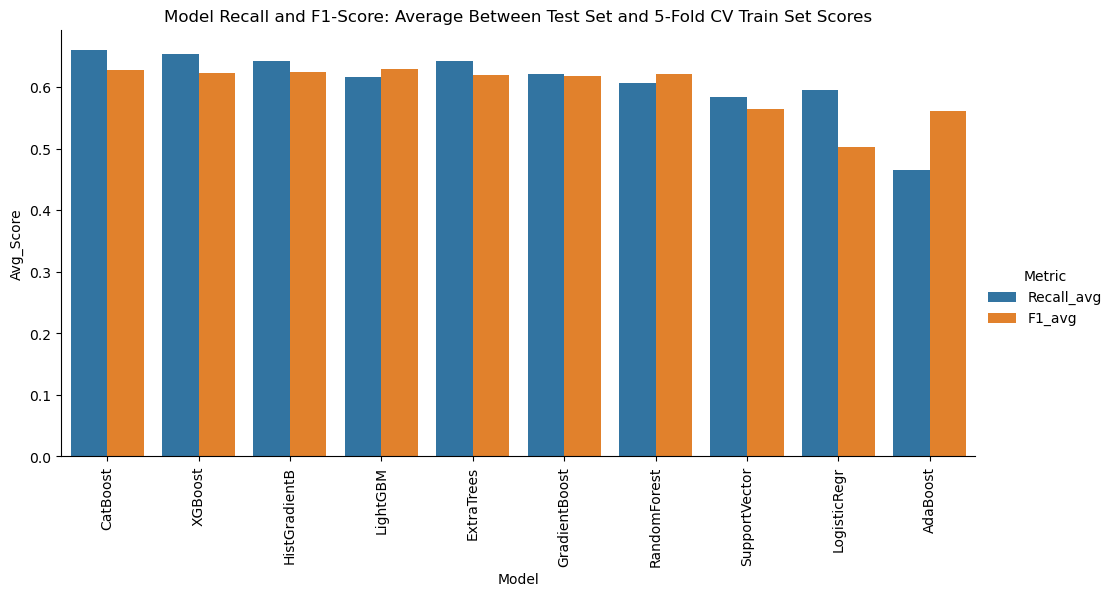

In [739]:
# Bar plot of each models' recall and f1-score: the metrics with the highest weight (average scores on train and test set)

scores_melt = pd.melt(scores_df, id_vars='Model', value_vars=['Recall_avg', 'F1_avg'],
                      var_name='Metric', value_name='Avg_Score')

ax = sns.catplot(scores_melt, kind='bar', x='Model', y='Avg_Score', hue='Metric', aspect=2)
plt.xticks(rotation=90)
plt.title('Model Recall and F1-Score: Average Between Test Set and 5-Fold CV Train Set Scores');

Before we make a final model selection, let's further evaluate the top 5 models and look at probability thresholds, features' contributions to model predictions, and model speed. 

## Model Evaluation: Top 5

In [825]:
# Top 5 models

top_models = {'CatBoost': models[7], 
              'XGBoost': models[5], 
              'HistGradientB': models[3],
              'LightGBM': models[6],
              'ExtraTrees': models[1]}

cb = models[7]
xg = models[5]
hg = models[3]
lg = models[6]
et = models[1]

In [749]:
# Print 2 classifcation reports for each model, 1 for the cross-validated train set predictions and 1 for the test set predictions

def class_reps(model_dict):               
    
    for n, m in model_dict.items():
    
        threshold = set_thresh(m)                   

        trues = np.array([], int)                                # Initialize array to store all combined true labels for each fold of cross-validation
        preds = np.array([], int)                                # Initialize arrray to store all combined predictions for each fold of cross-validation

        for tr, te in skf.split(X_train, y_train):
        
            X_tr, X_te = X_train.iloc[tr], X_train.iloc[te]
            y_tr, y_te = y_train.iloc[tr], y_train.iloc[te]
        
            te_prob = m.fit(X_tr, y_tr).predict_proba(X_te)[:, 1]   
            y_te_pred = np.where(te_prob < threshold, 0, 1) 
    
            trues = np.append(trues, y_te)
            preds = np.append(preds, y_te_pred)
        
        train_report = classification_report(trues, preds)                  # Generate classification report of all true labels and predictions
                                                                            #   aggregated from all folds of the train set cross-validation
        test_prob = m.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        y_test_pred = np.where(test_prob < threshold, 0, 1)
        
        test_report = classification_report(y_test, y_test_pred)            # Generate classification report of true labels predicitons from test set
        
        print(f'{n}\n')
        print(f'{"Train Report":<60} {"Test Report"}')

        for x, y in zip(train_report.split('\n'), test_report.split('\n')):        # Plot train and test reports side by side
            print(f'{x:<60} {y}')
            
        print('=' * 114 + '\n')

In [751]:
class_reps(top_models)

CatBoost

Train Report                                                 Test Report
              precision    recall  f1-score   support                      precision    recall  f1-score   support
                                                             
           0       0.91      0.89      0.90      6370                   0       0.91      0.88      0.90      1592
           1       0.60      0.65      0.62      1630                   1       0.60      0.67      0.63       408
                                                             
    accuracy                           0.84      8000            accuracy                           0.84      2000
   macro avg       0.76      0.77      0.76      8000           macro avg       0.76      0.78      0.77      2000
weighted avg       0.85      0.84      0.84      8000        weighted avg       0.85      0.84      0.84      2000
                                                             

XGBoost

Train Report                   

Though the classification reports present information that we have already considered in our model evaluation, they present a clean view of 4 of the success metrics, with respective scores assigned for positive and negative labels.

### Probability Thresholds

In [1021]:
# Best probability thresholds for top 5 models

best_thresh = {'CatBoost': 0.29, 
               'XGBoost': 0.3, 
               'HistGradientB': 0.31,
               'LightGBM': 0.34,
               'ExtraTrees': 0.32}

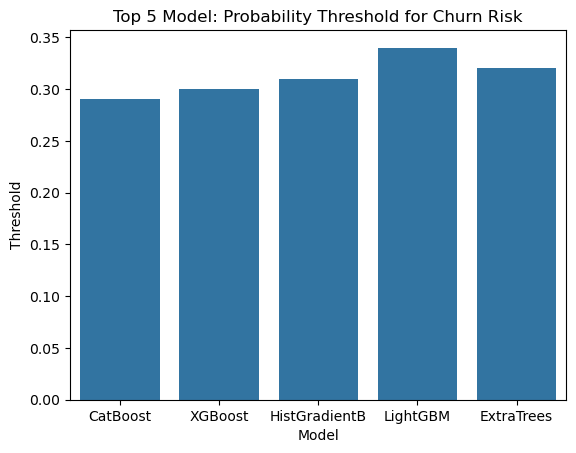

In [1095]:
# Create dataframe for model name and its probability threshold

thresh_df = pd.DataFrame.from_dict(best_thresh, orient='index').reset_index().rename(columns={'index': 'Model', 0: 'Threshold'})

# Bar plot of thresholds

ax = sns.barplot(thresh_df, x='Model', y='Threshold')
ax.set_title('Top 5 Model: Probability Threshold for Churn Risk');

Generally, we expect stakeholders to prefer a low probability theshold so as to be conservative in considering a customer's churn risk. Excepting LightGBM which has the highest probability threshold of our top 5 models, the others are ordered with a lower threshold corresponding with higher aggregate score. That's another win for CatBoost.

### Features Importancs / Shap Values

In the previous notebook, we looked at feature importances (FI) for each model. Let's revisit these for our top models, as well as Shapley (SHAP v) values. FI are calculated based upon a feature's impact on impurity reduction when it is used to split a node in a tree-based model. SHAP v are based on values from cooperative game theory and represent how strongly a feature contributes to the model output in a specific instance.

In [769]:
# Create dataframe of feature importances for a given model

def feat_frame(model):
    
    model.fit(X_train, y_train)
    fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':model.feature_importances_}).sort_values(
                       'Importance', ascending=False).reset_index(drop=True)                                  
    fi.index += 1
    return fi

In [915]:
# Calculate shap values for a given model

def shap_vals(model):
    
    model.fit(X_train, y_train)
    explainer = shap.explainers.Permutation(model.predict_proba, X_train)
    shap_values = explainer(X_train[:100])
    shap_values = shap_values[..., 1]
    return shap_values
    
    #return shap.plots.bar(shap_values)

In [1009]:
# Display bar plot of feature importances

def feat_plot(model, model_name):
    
    frame = feat_frame(model)
    shaps = shap_vals(model)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plt.subplots_adjust(wspace=0.6)
    fig.suptitle(model_name + ' Feature Importances vs. SHAP Values', fontsize=12)
    
    sns.barplot(frame, y='Feature', x='Importance', orient='h', ax=axes[0])
    shap.plots.bar(shaps, ax=axes[1])

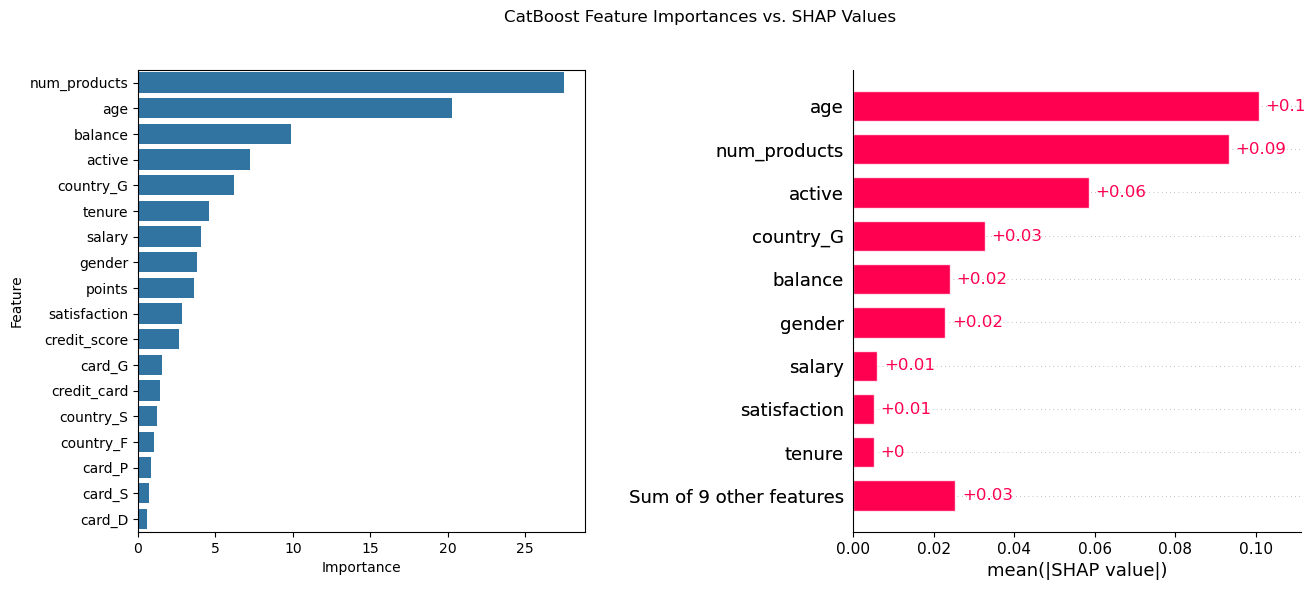

In [1011]:
feat_plot(cb, 'CatBoost')

FI and SHAP v both indicate 'number of products', 'age', 'balance', 'active', and 'Germany' to be the 5 most important features. FI puts 'number of products' 1st and 'age' 2nd; for SHAP v these are switched. FI places 'balance' in 3rd while SHAP v puts it in 5th; 'active' is in 4th and 3rd respectively; Germany' is in 5th and 4th respectively.

PermutationExplainer explainer: 101it [00:14,  2.23it/s]                         


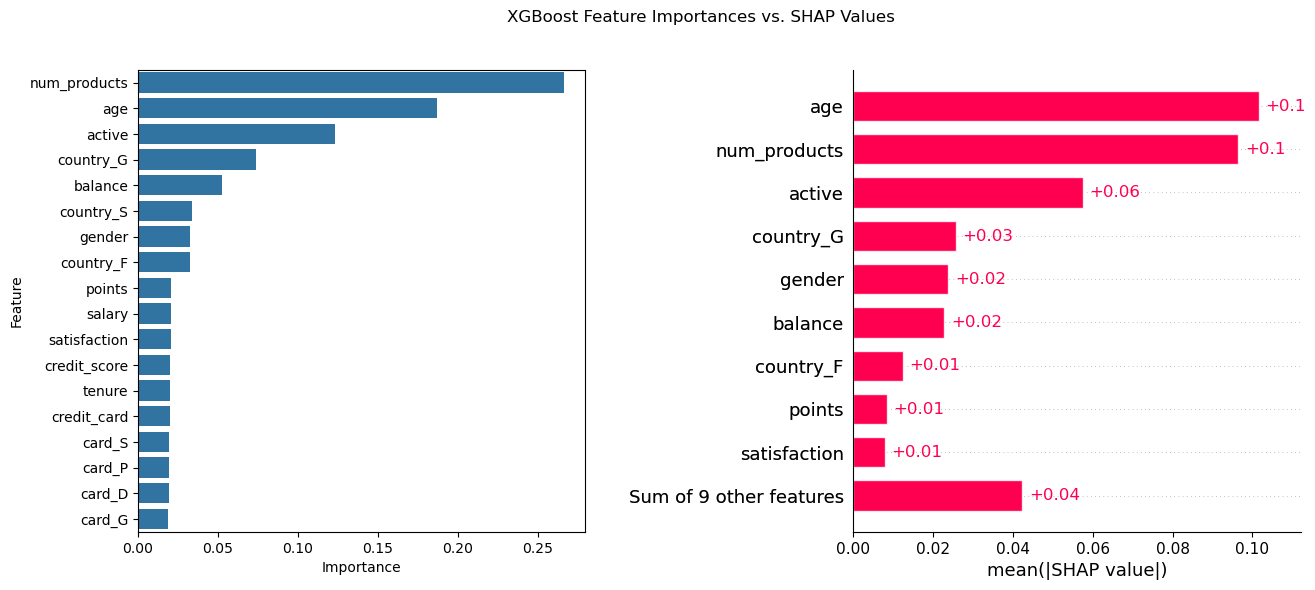

In [1110]:
feat_plot(xg, 'XGBoost')

XGBoost has the same top 5 FI as Catboost, in a different order but with the same first two. Likewise the SHAP v include the same top 4 in the same order, with 'gender' in 5th and 'balance' in 6th. XGBoost FI places 'gender' in 7th behind 'Spain'. CatBoost SHAP v places 'gender' in 6th.

PermutationExplainer explainer: 101it [00:49,  1.63it/s]                         


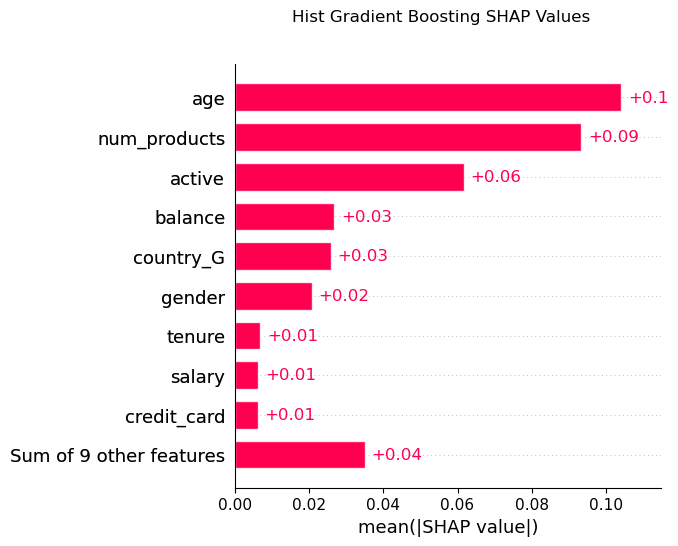

In [1142]:
# Only plot SHAP v for Hist Gradient Boosting, as it doesn't include a feature_importances_ attribute

fig, axes = plt.subplots(figsize=(5.5, 5.5))
fig.suptitle('Hist Gradient Boosting SHAP Values', fontsize=12)

shap.plots.bar(shap_vals(hg), ax=axes)

Hist Gradient Boosting has the same top 5 feature SHAP v order as Catboost, with 'balance' and 'Germany' switched.

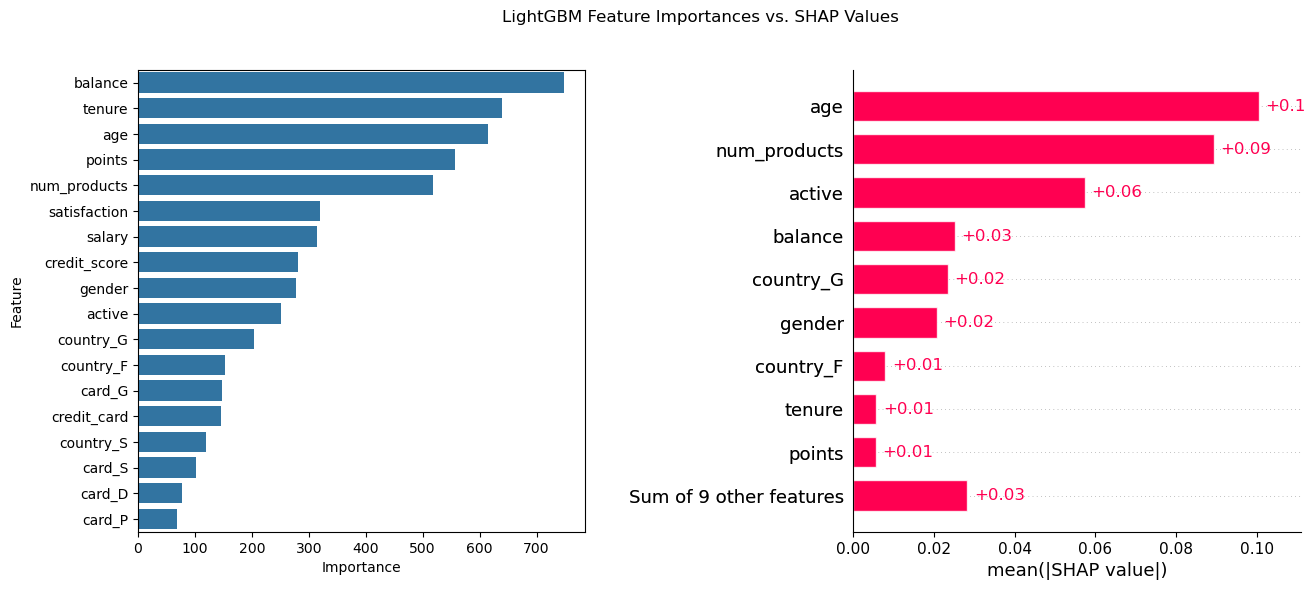

In [1147]:
feat_plot(lg, 'LightGBM')

LightGBM has the same top 6 SHAP v as Hist Gradient Boosting. It's FI are in a bit of a different order than other models, with 'age' and 'number of products' (the top 2 FI for previous models) in 3rd and 5th respectively. LightGBM FI places 'balance', 'tenure', and 'points' as the 1st, 2nd, and 4th most important features respectively.

PermutationExplainer explainer: 101it [05:59,  3.67s/it]                         


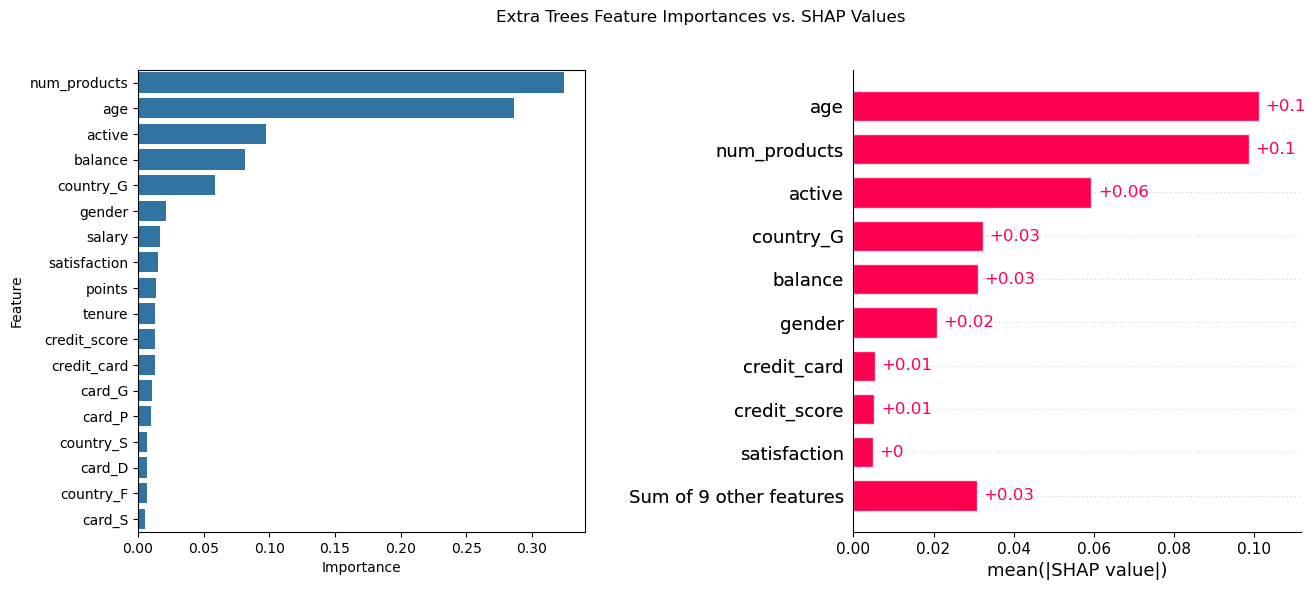

In [1152]:
feat_plot(et, 'Extra Trees')

Extra Trees has the same top 6 SHAP v as CatBoost. It also mirrors these values in FI, with 'num_products' and 'age' swithed for 1st and 2nd, and 'balance' and 'Germany' switched for 4th and 5th.

The models' FI and SHAP values overlapped on some features relative contribution and different on others. While models also varied somewhat from one another, the overall consistent ranking places the following features as the key factors to consider regarding customer retention:
- Age
- Number of products
- Active
- Germany
- Balance
- Gender

We will review some counts of churn cases from our sample for each of these features' binned value ranges.

In [1747]:
# Dataframe of most important features
# Include target variable: 'churn', and golden feature: 'complain'

df_tf = df[['churn', 'age', 'num_products', 'active', 'country_G', 'balance', 'gender', 'complain']]

In [1749]:
# Re-label feature bin numbers with text and value ranges
    
df_tf.loc[df_tf['age'] == 0, 'age'] = '<25'                        
df_tf.loc[df_tf['age'] == 1, 'age'] = '25-34'
df_tf.loc[df_tf['age'] == 2, 'age'] = '35-44'
df_tf.loc[df_tf['age'] == 3, 'age'] = '45-54'
df_tf.loc[df_tf['age'] == 4, 'age'] = '55-64'
df_tf.loc[df_tf['age'] == 5, 'age'] = '65+'

df_tf.loc[df_tf['num_products'] == 1, 'num_products'] = '1'
df_tf.loc[df_tf['num_products'] == 2, 'num_products'] = '2'
df_tf.loc[df_tf['num_products'] == 3, 'num_products'] = '3+'

df_tf.loc[df_tf['active'] == 0, 'active'] = 'No'
df_tf.loc[df_tf['active'] == 1, 'active'] = 'Yes'

df_tf.rename(columns={'country_G': 'country'}, inplace=True)
df_tf.loc[df_tf['country'] == 0, 'country'] = 'France & Spain'
df_tf.loc[df_tf['country'] == 1, 'country'] = 'Germany'

df_tf.loc[df_tf['balance'] == 0, 'balance'] = '0'
df_tf.loc[df_tf['balance'] == 1, 'balance'] = '(0, 100k)'
df_tf.loc[df_tf['balance'] == 2, 'balance'] = '[100k, 150k)'
df_tf.loc[df_tf['balance'] == 3, 'balance'] = '150k+'

df_tf.loc[df_tf['gender'] == 0, 'gender'] = 'Female'
df_tf.loc[df_tf['gender'] == 1, 'gender'] = 'Male'

df_tf.loc[df_tf['complain'] == 0, 'complain'] = 'No'                  
df_tf.loc[df_tf['complain'] == 1, 'complain'] = 'Yes'

In [1751]:
# Dataframe of top features for only churned customers 

df_churn = df_tf.copy()
df_churn = df_churn[df_churn['churn'] == 1]

#### Age

In [1605]:
# Percentage that churned per age bracket
# Customers in age bracket that churned divided by total customers in age bracket

ab1 = str(round(df_churn['age'].value_counts().loc['<25'] / df_tf['age'].value_counts().loc['<25'] * 100)) + '%'
ab2 = str(round(df_churn['age'].value_counts().loc['25-34'] / df_tf['age'].value_counts().loc['25-34'] * 100)) + '%'
ab3 = str(round(df_churn['age'].value_counts().loc['35-44'] / df_tf['age'].value_counts().loc['35-44'] * 100)) + '%'
ab4 = str(round(df_churn['age'].value_counts().loc['45-54'] / df_tf['age'].value_counts().loc['45-54'] * 100)) + '%'
ab5 = str(round(df_churn['age'].value_counts().loc['55-64'] / df_tf['age'].value_counts().loc['55-64'] * 100)) + '%'
ab6 = str(round(df_churn['age'].value_counts().loc['65+'] / df_tf['age'].value_counts().loc['65+'] * 100)) + '%'

per_age_labels = [ab1, ab2, ab3, ab4, ab5, ab6]

# Percentage that churned by age bracket
# Customers in age bracket that churned divided by total number of churned customers

at1 = str(round(df_churn['age'].value_counts().loc['<25'] / len(df_churn) * 100)) + '%'
at2 = str(round(df_churn['age'].value_counts().loc['25-34'] / len(df_churn) * 100)) + '%'
at3 = str(round(df_churn['age'].value_counts().loc['35-44'] / len(df_churn) * 100)) + '%'
at4 = str(round(df_churn['age'].value_counts().loc['45-54'] / len(df_churn) * 100)) + '%'
at5 = str(round(df_churn['age'].value_counts().loc['55-64'] / len(df_churn) * 100)) + '%'
at6 = str(round(df_churn['age'].value_counts().loc['65+'] / len(df_churn) * 100)) + '%'

by_age_labels = [at1, at2, at3, at4, at5, at6]

# Ordered labels for x axis

age_order = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']

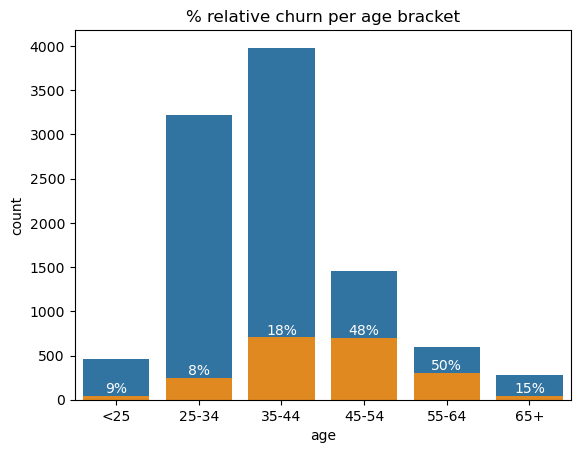

In [1659]:
# Plot percentage of relative churn per age bracket

sns.countplot(df_tf, x='age', order=age_order)
ax = sns.countplot(df_churn, x='age', order=age_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_age_labels, c='w')
ax.set_title('% relative churn per age bracket');

Interpreting churn in relation to the proportion of total customers in a given age bracket that churned, we see that about half of customers betweeen 45-64 churned. From this angle, we could say that these customers age ranges should be high priority. Customers between 35-44 and 65+ are also above the 10% threshold, while customers below 35 are under the threshold.

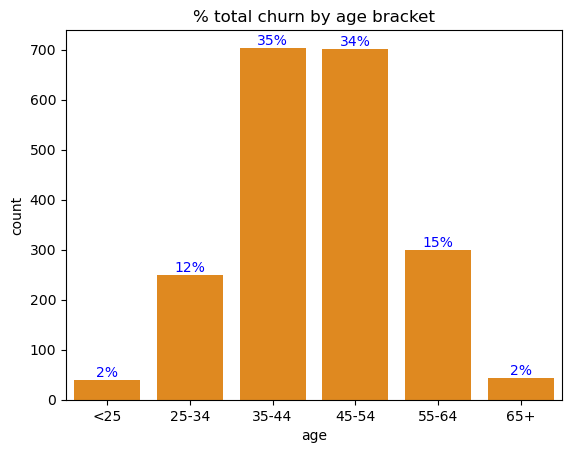

In [1661]:
# Plot percentage of total churned customers in each age bracket

ax = sns.countplot(df_churn, x='age', order=age_order, color='darkorange')
ax.bar_label(ax.containers[0], labels=by_age_labels, c='b')
ax.set_title('% total churn by age bracket');

Viewing the proportions in regards to percentage of churned customers from a given age bracket out of the total churn, we see that customers age 35-44 make up the highest overall percentage. This is because, though 18% of these customers churned as opposed to 50% of customers between 55-64, customers between 35-44 make up the largest portion of any age bracket in our sample, accounting for about 40% of the entire sample population. 18% of 4000 is more than 50% of 750. From this angle, we could say that the primary age range we should prioritze is 35-54, as the majority of overall churn cases come from these age ranges.

#### Number of Products

In [1671]:
# Percentage that churned per number of products
# Customers with given number of products that churned divided by total customers with that many products

nb1 = str(round(df_churn['num_products'].value_counts().loc['1'] / df_tf['num_products'].value_counts().loc['1'] * 100)) + '%'
nb2 = str(round(df_churn['num_products'].value_counts().loc['2'] / df_tf['num_products'].value_counts().loc['2'] * 100)) + '%'
nb3 = str(round(df_churn['num_products'].value_counts().loc['3+'] / df_tf['num_products'].value_counts().loc['3+'] * 100)) + '%'

per_num_products_labels_1 = [nb1, nb2, '']
per_num_products_labels_2 = ['', '', nb3]                 # Label over total bar because churn covers too much of total to see label above churn

# Percentage that churned by number of products
# Customers with given number of products that churned divided by total number of churned customers

nt1 = str(round(df_churn['num_products'].value_counts().loc['1'] / len(df_churn) * 100)) + '%'
nt2 = str(round(df_churn['num_products'].value_counts().loc['2'] / len(df_churn) * 100)) + '%'
nt3 = str(round(df_churn['num_products'].value_counts().loc['3+'] / len(df_churn) * 100)) + '%'

by_num_products_labels = [nt1, nt2, nt3]

# Ordered labels for x axis

num_products_order = ['1', '2', '3+']

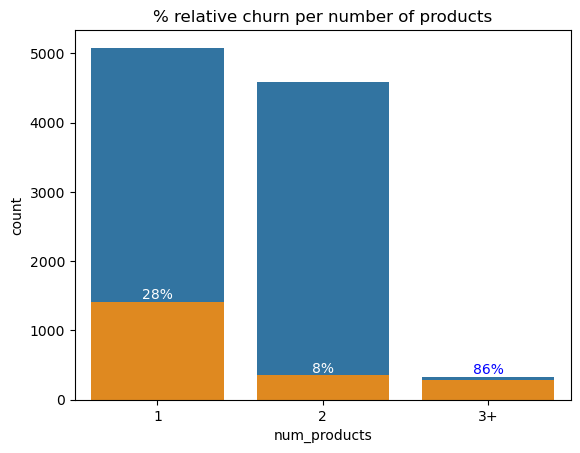

In [1675]:
# Plot percentage of relative churn per number of products

sns.countplot(df_tf, x='num_products', order=num_products_order)
ax = sns.countplot(df_churn, x='num_products', order=num_products_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_num_products_labels_1, c='w')
ax.bar_label(ax.containers[0], labels=per_num_products_labels_2, c='b')
ax.set_title('% relative churn per number of products');

From this view, it's clearn that most of the customers with 3 or 4 products churn. Perhaps the type of customer who uses more than two products is less likely to retain, or perhaps Fairway has issues supporting customers with more than 2 products. Either way, one action item should be to tend to this market segment and maybe limit the number of products a customer can use to 2. We also see that customers with ony 1 product are over the 10% threshold. The only product number below our ideal threshold is 2, with 8% churn. Another strategy might be to try to prompt customers with only 1 product to move up to 2 products.

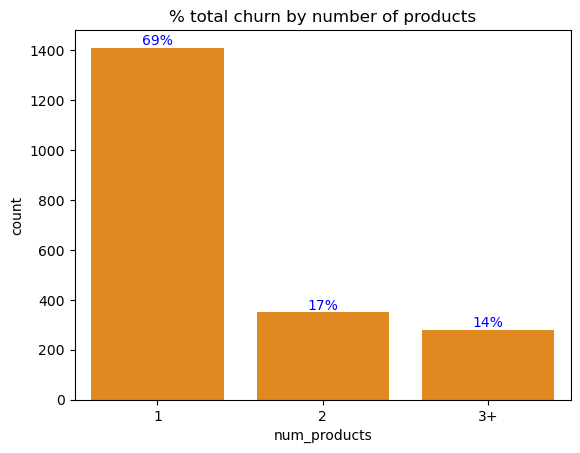

In [1679]:
# Plot percentage of total churned customeres with each number of products

ax = sns.countplot(df_churn, x='num_products', order=num_products_order, color='darkorange')
ax.bar_label(ax.containers[0], labels=by_num_products_labels, c='b')
ax.set_title('% total churn by number of products');

From this angle, the data demonstrate that by far the largest portion of churn comes from customers with 1 product, as total customers with 1 product make up the largest portion of the sample population relative to other products. Though there are far more customers with 2 products than 3 or more, the percentage of churn between these two product counts are close, at 17% and 14% respectively, again highlighting the vast proportion of customers with 3 or 4 products that churn.

#### Active

In [1695]:
# Percentage that churned per whether or not customer is active
# Active/inactive customers that churned divided by total active/inactive customers respectively

acb1 = str(round(df_churn['active'].value_counts().loc['No'] / df_tf['active'].value_counts().loc['No'] * 100)) + '%'
acb2 = str(round(df_churn['active'].value_counts().loc['Yes'] / df_tf['active'].value_counts().loc['Yes'] * 100)) + '%'

per_active_labels = [acb1, acb2]

# Percentage that churned by whether or not customer is active
# Active/inactive customers that churned divided by total number of churned customers

act1 = str(round(df_churn['active'].value_counts().loc['No'] / len(df_churn) * 100)) + '%'
act2 = str(round(df_churn['active'].value_counts().loc['Yes'] / len(df_churn) * 100)) + '%'

by_active_labels = [act1, act2]

# Ordered labels for x axis

active_order = ['No', 'Yes']

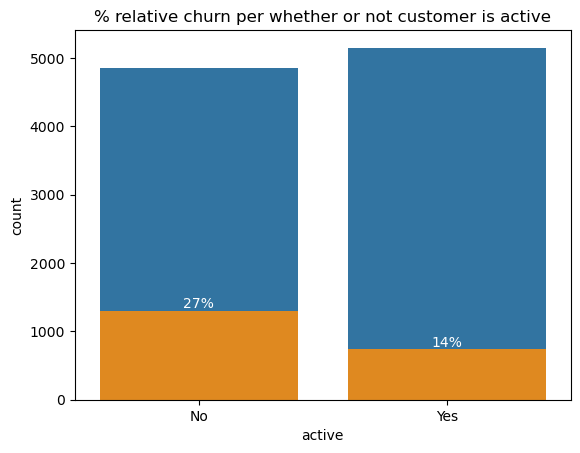

In [1690]:
# Plot percentage of relative churn per whether or not customer is active

sns.countplot(df_tf, x='active', order=active_order)
ax = sns.countplot(df_churn, x='active', order=active_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_active_labels, c='w')
ax.set_title('% relative churn per whether or not customer is active');

Here we see that even though there are more active customers, there are more churned inactive customers, as the proportion of total inactive customers who churned is almost twice that of active customers who churned.

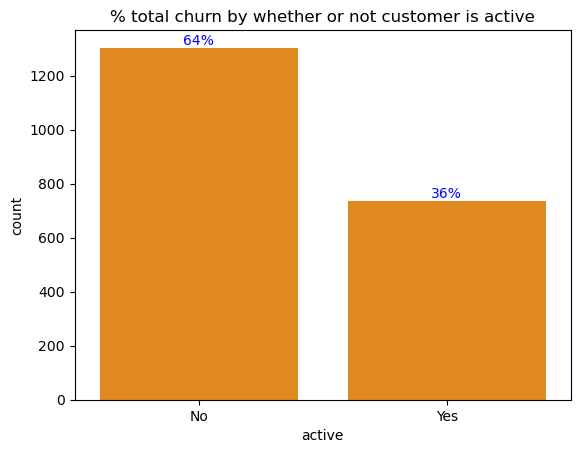

In [1697]:
# Plot percentage of total churned customeres with each number of products

ax = sns.countplot(df_churn, x='active', order=active_order, color='darkorange')
ax.bar_label(ax.containers[0], labels=by_active_labels, c='b')
ax.set_title('% total churn by whether or not customer is active');

Of all churned customers, almost 2/3 are inactive.

#### Country

In [1707]:
# Percentage that churned per whether or not customer is in Germany
# German/non-German customers that churned divided by total German/non-German customers respectively

gb1 = str(round(df_churn['country'].value_counts().loc['Germany'] / df_tf['country'].value_counts().loc['Germany'] * 100)) + '%'
gb2 = str(round(df_churn['country'].value_counts().loc['France & Spain'] / df_tf['country'].value_counts().loc['France & Spain'] * 100)) + '%'

per_country_labels = [gb1, gb2]

# Percentage that churned by whether or not customer is in Germany
# German/non-German customers that churned divided by total number of churned customers

gt1 = str(round(df_churn['country'].value_counts().loc['Germany'] / len(df_churn) * 100)) + '%'
gt2 = str(round(df_churn['country'].value_counts().loc['France & Spain'] / len(df_churn) * 100)) + '%'

by_country_labels = [gt1, gt2]

# Ordered labels for x axis

country_order = ['Germany', 'France & Spain']

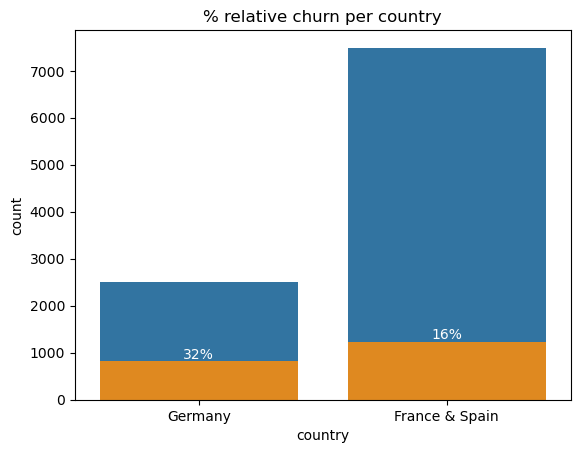

In [1709]:
# Plot percentage of relative churn per country

sns.countplot(df_tf, x='country', order=country_order)
ax = sns.countplot(df_churn, x='country', order=country_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_country_labels, c='w')
ax.set_title('% relative churn per country');

Relative to the total proportion of the sample in Germany or France/Spain, twice the percentage of German customers churned than that of the French and Spanish. We also see that German customers only make up about 1/3 of total customers, so the number of customers that churned in Germany is still less than that of the combined France & Spain, but it's certainly over half these 2 combined countries' churn counts.

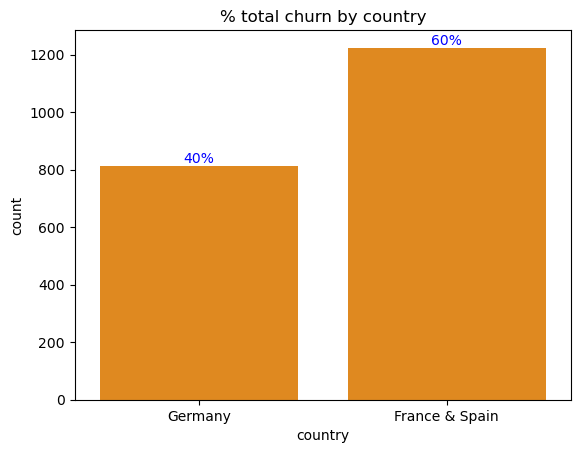

In [1712]:
# Plot percentage of total churned customeres from Germany and France/Spain

ax = sns.countplot(df_churn, x='country', order=country_order, color='darkorange')
ax.bar_label(ax.containers[0], labels=by_country_labels, c='b')
ax.set_title('% total churn by country');

We see a 2:3 ratio between churned customers in Germany alone, and the combined French and Spanish churned customers.

#### Balance

In [1753]:
df_churn['balance'].value_counts()

balance
[100k, 150k)    987
0               500
(0, 100k)       327
150k+           224
Name: count, dtype: int64

In [1770]:
# Percentage that churned per balance bracket
# Customers within a given balance bracket that churned divided by total customers within that balance bracket

bb1 = str(round(df_churn['balance'].value_counts().loc['0'] / df_tf['balance'].value_counts().loc['0'] * 100)) + '%'
bb2 = str(round(df_churn['balance'].value_counts().loc['(0, 100k)'] / df_tf['balance'].value_counts().loc['(0, 100k)'] * 100)) + '%'
bb3 = str(round(df_churn['balance'].value_counts().loc['[100k, 150k)'] / df_tf['balance'].value_counts().loc['[100k, 150k)'] * 100)) + '%'
bb4 = str(round(df_churn['balance'].value_counts().loc['150k+'] / df_tf['balance'].value_counts().loc['150k+'] * 100)) + '%'

per_balance_labels = [bb1, bb2, bb3, bb4]

# Percentage that churned by balance bracket
# Customers within a given balance bracket that churned divided by total number of churned customers

bt1 = str(round(df_churn['balance'].value_counts().loc['0'] / len(df_churn) * 100)) + '%'
bt2 = str(round(df_churn['balance'].value_counts().loc['(0, 100k)'] / len(df_churn) * 100)) + '%'
bt3 = str(round(df_churn['balance'].value_counts().loc['[100k, 150k)'] / len(df_churn) * 100)) + '%'
bt4 = str(round(df_churn['balance'].value_counts().loc['150k+'] / len(df_churn) * 100)) + '%'

by_balance_labels = [bt1, bt2, bt3, bt4]

# Ordered labels for x axis

balance_order = ['0', '(0, 100k)', '[100k, 150k)', '150k+']

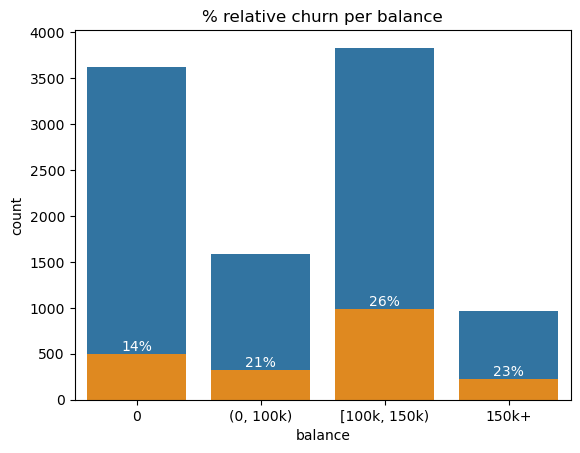

In [1772]:
# Plot percentage of relative churn per number of products

sns.countplot(df_tf, x='balance', order=balance_order)
ax = sns.countplot(df_churn, x='balance', order=balance_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_balance_labels, c='w')
ax.set_title('% relative churn per balance');

Though customers with a balance of 150k+ make up the smallest proportion of balance brackets, it has the second highest inner-bracket churn ratio, second to the \[100k, 150k) bracket makes up the largest proportion of customers.

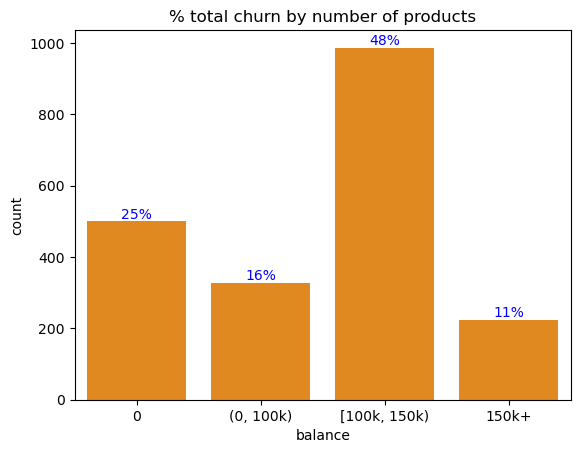

In [1775]:
# Plot percentage of total churned customeres with each number of products

ax = sns.countplot(df_churn, x='balance', order=balance_order, color='darkorange')
ax.bar_label(ax.containers[0], labels=by_balance_labels, c='b')
ax.set_title('% total churn by number of products');

Almost have of total churned customers come from the \[100k, 150k) bracket and 1/4 have a balance of 0.

#### Gender

In [1725]:
# Percentage that churned per gender
# Female/male customers that churned divided by total female/male customers respectively

sb1 = str(round(df_churn['gender'].value_counts().loc['Female'] / df_tf['gender'].value_counts().loc['Female'] * 100)) + '%'
sb2 = str(round(df_churn['gender'].value_counts().loc['Male'] / df_tf['gender'].value_counts().loc['Male'] * 100)) + '%'

per_gender_labels = [sb1, sb2]

# Percentage that churned by gender
# Female/male customers that churned divided by total number of churned customers

st1 = str(round(df_churn['gender'].value_counts().loc['Female'] / len(df_churn) * 100)) + '%'
st2 = str(round(df_churn['gender'].value_counts().loc['Male'] / len(df_churn) * 100)) + '%'

by_gender_labels = [st1, st2]

# Ordered labels for x axis

gender_order = ['Female', 'Male']

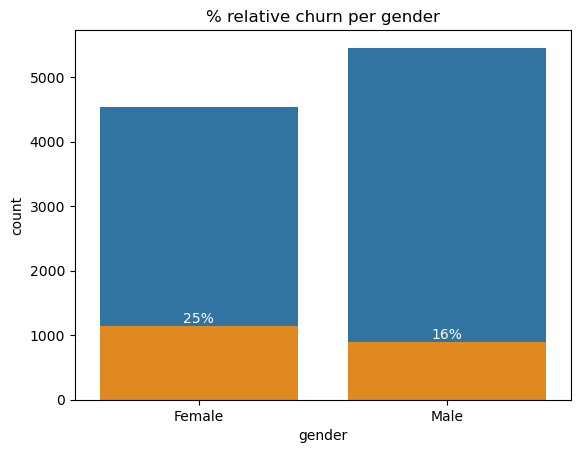

In [1727]:
# Plot percentage of relative churn per gender

sns.countplot(df_tf, x='gender', order=gender_order)
ax = sns.countplot(df_churn, x='gender', order=gender_order, color='darkorange')
ax.bar_label(ax.containers[1], labels=per_gender_labels, c='w')
ax.set_title('% relative churn per gender');

While there are more male customers than female customers, more total female customers churned, making up 1/4 of total female customers.

Reviewing the features that our models generally highlighted as having the most influence on churn, illuminated the notion that we can assess these data from the angle of the inner-category churn proportion, or the total churn count per category, regardless of how large of a total customer proportion that category represents. Both strategies offer valualbe insights into how churn is reflected across features, and actionable interpretations will need to be discussed with stakeholders. In the meantime, let's review a final model performance metric before selecting our official best model.

### Model Speed

In [1826]:
# Time it takes each model to fit to and predict on entire dataset

for key, val in top_models.items():
    print(key)
    %timeit val.fit(X, y).predict_proba(X)
    print('\n')

CatBoost
1.44 s ± 74.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


XGBoost
2.63 s ± 254 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


HistGradientB
2.39 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


LightGBM
191 ms ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


ExtraTrees
5.35 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)




From this simple test we see that LightGBM is significantly our fastest model and Extra Trees is significantly our slowest model. CatBoost comes in 2nd place. In this case, we recommend sacrificing a little speed given that CatBoost has the highest weighted aggregate score across the various score metrics that we assessed, and that it uses the lowest proability threshold of our top models. With a choice decided, we are ready to go to stakeholders and discuss the next steps.

## Top Model: Overall

# CatBoost !! 😸 🚀

In [1850]:
# Hyperparameter settings

cb.get_params()

{'iterations': 545,
 'learning_rate': 0.013560631530876574,
 'depth': 6,
 'l2_leaf_reg': 2.548492629309027,
 'verbose': 0,
 'random_strength': 0.3660344916841721,
 'bagging_temperature': 0.2722303737601264,
 'random_state': 42}

In [1862]:
# Probability threshold

best_thresh['CatBoost']

0.29

In [1876]:
# Model scores

scores_df[scores_df['Model'] == 'CatBoost'].T

,1
Model,CatBoost
Recall_tr,0.647239
Recall_sd,0.022852
Recall_te,0.67402
F1_tr,0.62387
F1_sd,0.018232
F1_te,0.632911
Prec_tr,0.602409
Prec_sd,0.01952
Prec_te,0.596529


## Summary

We began this notebook with 10 prospective tuned models with the goal of selecting 1 to present to stakeholders. In order to pick a best model, we looked at each model’s recall, f1-score, precision, accuracy, and ROC AUC for both 5-fold cross-validated train set predictions (including standard deviations across the 5 train scores per model) and test set predictions. We excluded the golden feature: complain from these datasets, as this feature is almost 100% proportional to churn. To pick a best overall model, we assigned weights to each score relative to our business needs of optimizing true negatives (recall was our heaviest metric, followed by f1-score) and summed them up to generate aggregate scores across models. We then took the 5 models with the highest scores to examine more closely:
- CatBoost
- XGBoost
- Hist Gradient Boosting
- LightGBM
- Extra Trees

We also examined probability thresholds and model speed of our top 5 models. CatBoost has the lowest probability threshold of 0.29 and finished second fastest to LightGBM in fitting and predicting probabilities on the entire 10k sample dataset. CatBoost was thus selected as our choice model

We also performed additional EDA to examine the top features for our models, as determined by feature importances and SHAP values. Overall, the primary features of interest are:
- age
- number of products
- active
- Germany
- balance
- gender

We are now ready to discuss the next steps with stakeholders and proceed to make churn predictions on all of Fairway’s existing customers and incoming customers, as well as discuss how the features’ contribution to churn predictions can help inform business decisions on actions that we should prioritize. Now let’s get to work on optimizing customer retention!